# Physiology Lab - Fall 2019
# Oxygen Equilibrium of Hemocyanin Report

For this report, Dr. Beers only wants three graphs generated from the data obtained during lab. 

1. Plot % Oxygen Saturation (y-axis) as a funciton of oxygen partial pressure (x-axis). Determine the P<sub>50</sub> of the pigment under the experimental conditions.

In [1]:
hemodat = read.csv('OxygenEqHemo.csv')
hemodat$pH = as.factor(hemodat$pH)

In [2]:
hemodat$hill = log((hemodat$Percent.Oxy.Sat)*100/(100-(hemodat$Percent.Oxy.Sat*100)))
max(hemodat$PO2)

[1] 117.462

In [48]:
head(hemodat)

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,0.00000000,-Inf
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894


In [58]:
hem_73 = hemodat[hemodat$pH == '7.3',]
hem_68 = hemodat[hemodat$pH == '6.8',]
hem_78 = hemodat[hemodat$pH == '7.8',]
hem_73
hem_68
a = rbind(hem_68, hem_73)

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,0.00000000,-Inf
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894
7.3,70,0.201,764.25,24.195,610,84.924344,0.72118959,0.9503700
7.3,75,0.223,764.25,24.195,610,90.990369,0.80297398,1.4049865


,pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
9,6.8,0,0.049,768.8132,22.92939,635,0.00000,0.00000000,-Inf
10,6.8,10,0.056,768.8132,22.92939,635,11.74620,0.02017291,-3.8830355
11,6.8,20,0.077,768.8132,22.92939,635,23.49240,0.08069164,-2.4329866
12,6.8,40,0.103,768.8132,22.92939,635,46.98481,0.15561960,-1.6911886
13,6.8,60,0.141,768.8132,22.92939,635,70.47721,0.26512968,-1.0194750
14,6.8,80,0.179,768.8132,22.92939,635,93.96961,0.37463977,-0.5123629
15,6.8,100,0.195,768.8132,22.92939,635,117.46202,0.42074928,-0.3196983


In [4]:
require(nlme)
require(ggplot2)
require(ggpubr)

Loading required package: nlme

Loading required package: ggplot2

Loading required package: ggpubr

Loading required package: magrittr



In [5]:
fit_68 = nls(Percent.Oxy.Sat~SSlogis(PO2, Asym, xmid, scal), data=hem_68)
summary(fit_68)


Formula: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
Asym  0.44591    0.02696  16.542 7.82e-05 ***
xmid 61.02375    4.13062  14.774 0.000122 ***
scal 20.30299    2.66040   7.632 0.001583 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01753 on 4 degrees of freedom

Number of iterations to convergence: 0 
Achieved convergence tolerance: 6.763e-06


In [6]:
hem_68

,pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
,<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
9,6.8,0,0.049,768.8132,22.92939,635,0.00000,0.00000000,-Inf
10,6.8,10,0.056,768.8132,22.92939,635,11.74620,0.02017291,-3.8830355
11,6.8,20,0.077,768.8132,22.92939,635,23.49240,0.08069164,-2.4329866
12,6.8,40,0.103,768.8132,22.92939,635,46.98481,0.15561960,-1.6911886
13,6.8,60,0.141,768.8132,22.92939,635,70.47721,0.26512968,-1.0194750
14,6.8,80,0.179,768.8132,22.92939,635,93.96961,0.37463977,-0.5123629
15,6.8,100,0.195,768.8132,22.92939,635,117.46202,0.42074928,-0.3196983


In [46]:
fit_73 = nls(Percent.Oxy.Sat~SSlogis(PO2,Asym,xmid,scal), data=hem_73)
summary(fit_73)
#plot(Percent.Oxy.Sat~PO2,data=hem_73,type="p")
nd = seq(from = 0, to = max(hem_73$PO2), 0.1)
#points(predict(fit73, newdata=nd)~PO2, data=hem_73, type="l")


Formula: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)

Parameters:
     Estimate Std. Error t value Pr(>|t|)    
Asym  0.91703    0.04591   19.97 5.81e-06 ***
xmid 60.52664    2.43492   24.86 1.97e-06 ***
scal 16.73787    1.31638   12.71 5.35e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01674 on 5 degrees of freedom

Number of iterations to convergence: 0 
Achieved convergence tolerance: 1.228e-06


[1] 0.02103399 0.03617600 0.06066214 0.14880216 0.27394215 0.37240862 0.41985593

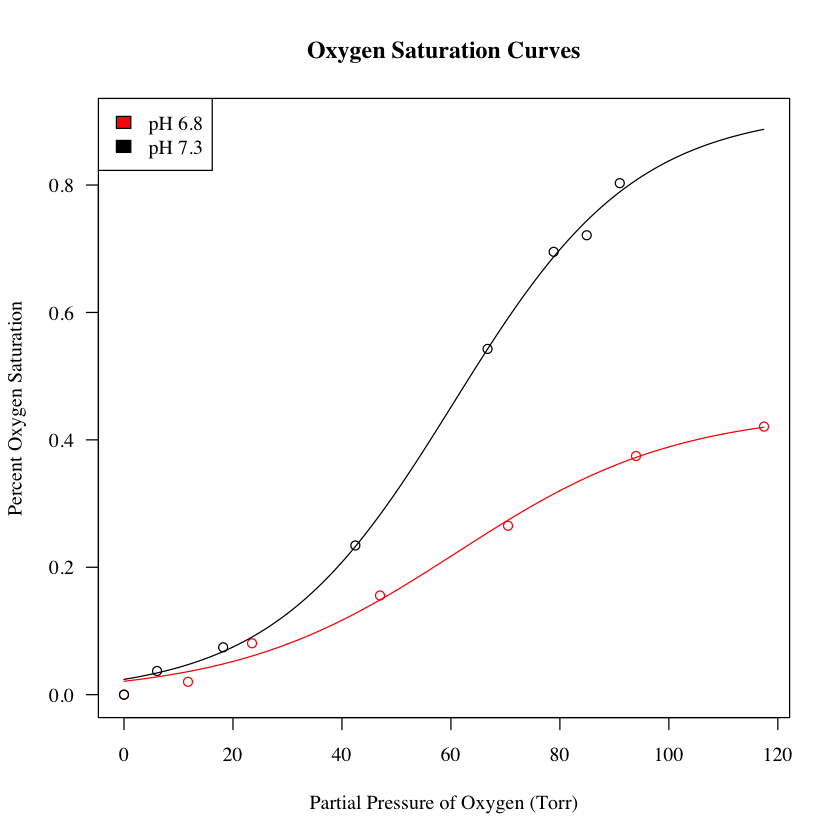

In [133]:
predict(fit_68)
opar = par(las = 1)
#png(filename="OxygenSatCurves.png")
par(family = "serif")
plot(Percent.Oxy.Sat ~ PO2, data = hem_68, ylim=c(0,0.9), main = "Oxygen Saturation Curves",
    ylab="Percent Oxygen Saturation",
    xlab="Partial Pressure of Oxygen (Torr)",
    col="red")
legend("topleft", 
        c("pH 6.8", "pH 7.3"),
        fill=c("red","black"))
tt = seq(0, max(hem_68$PO2), 0.1)
lines(tt, predict(fit_68, list(PO2 = tt)), col="red")
points(x = hem_73$PO2, y = hem_73$Percent.Oxy.Sat)
lines(tt, predict(fit_73, list(PO2 = tt)))
#dev.off()
par(opar)

In [9]:
# This ultimately refused to fit because we had less than 5 data points
fit_78 = nls(Percent.Oxy.Sat~SSlogis(PO2, Asym, xmid, scal), data = hem_78)
fit_78

Nonlinear regression model
  model: Percent.Oxy.Sat ~ SSlogis(PO2, Asym, xmid, scal)
   data: hem_78
   Asym    xmid    scal 
 0.9385 24.9705  2.1479 
 residual sum-of-squares: 7.035e-11

Number of iterations to convergence: 0 
Achieved convergence tolerance: 1.111e-09

2. Estimate the cooperativity of the hemocyanin (i.e. Create a Hill Plot). An estimate of cooperativity between hemocyanin subunits can be obtained by plotting the log of percent saturation ove rpercent unsaturation as a function of the log of Po<sub>2</sub> and measuring the slope of the line around P<sub>50</sub> (n or sometimes n<sub>50</sub>). This number is an indec of cooperativity. The higher the number, the grater the cooperativity.


Call:
lm(formula = hill ~ log(PO2), data = hem_73[hem_73$PO2 != 0, 
    ])

Residuals:
      2       3       4       5       6       7       8 
 0.5685 -0.6034 -0.7352 -0.1625  0.2009  0.1984  0.5334 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.9476     0.8784  -7.909 0.000520 ***
log(PO2)      1.7335     0.2295   7.552 0.000645 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5689 on 5 degrees of freedom
Multiple R-squared:  0.9194,	Adjusted R-squared:  0.9033 
F-statistic: 57.03 on 1 and 5 DF,  p-value: 0.0006453


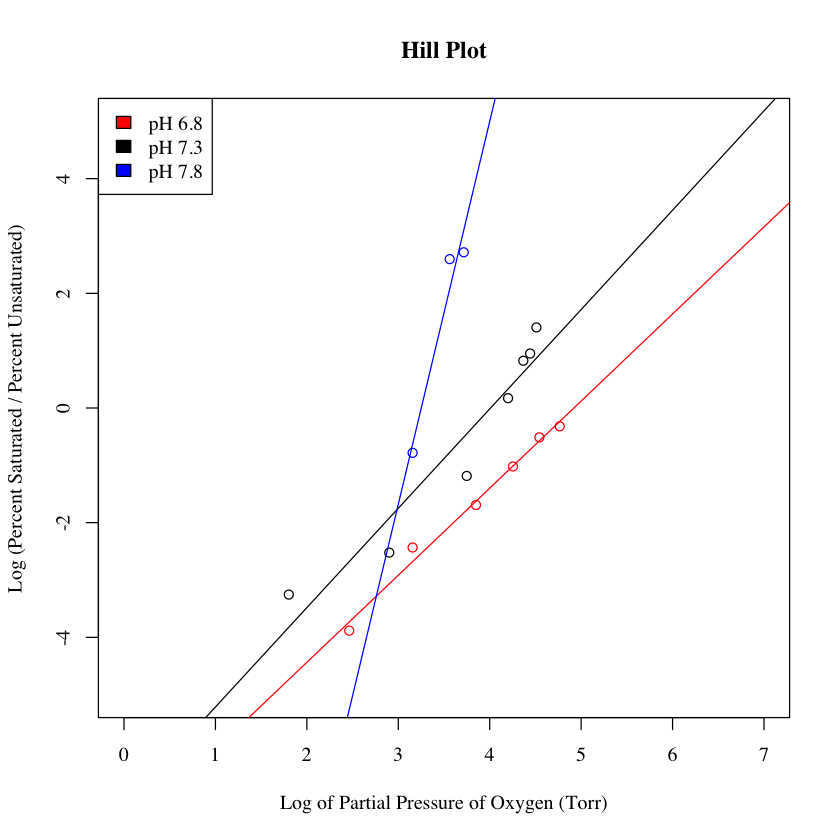

In [135]:
summary(lm(hill~log(PO2), data=hem_73[hem_73$PO2 != 0,]))
#png(filename="HillPlot.png")
par(family = 'serif')
plot(hill~log(PO2), data=hem_73[hem_73$PO2 != 0,], xlim = c(0, 7), ylim=c(-5,5),
    xlab="Log of Partial Pressure of Oxygen (Torr)",
    ylab="Log (Percent Saturated / Percent Unsaturated)",
    main="Hill Plot")
legend("topleft",
      c("pH 6.8", "pH 7.3", "pH 7.8"),
        fill=c("red","black", "blue"))
abline(a = -6.948, b = 1.733)
# Adding pH 6.8 to the graph
points(x=log(hem_68$PO2[hem_68$PO2 != 0]), y=hem_68$hill[hem_68$PO2 != 0], col="red")
abline(a = -7.47379, b = 1.51877, col="red")
# Adding pH 7.8 to the graph
points(x=log(hem_78$PO2[hem_78$PO2 != 0]), y=hem_78$hill[hem_78$PO2 != 0], col="blue")
abline(a=-21.704, b=6.674, col="blue")
#dev.off()


Call:
lm(formula = hill ~ log(PO2), data = hem_68[hem_68$PO2 != 0, 
    ])

Residuals:
       10        11        12        13        14        15 
-0.150785  0.246532 -0.064401 -0.008495  0.061694 -0.084545 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.47379    0.31255  -23.91 1.81e-05 ***
log(PO2)     1.51877    0.07968   19.06 4.46e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1571 on 4 degrees of freedom
Multiple R-squared:  0.9891,	Adjusted R-squared:  0.9864 
F-statistic: 363.3 on 1 and 4 DF,  p-value: 4.463e-05


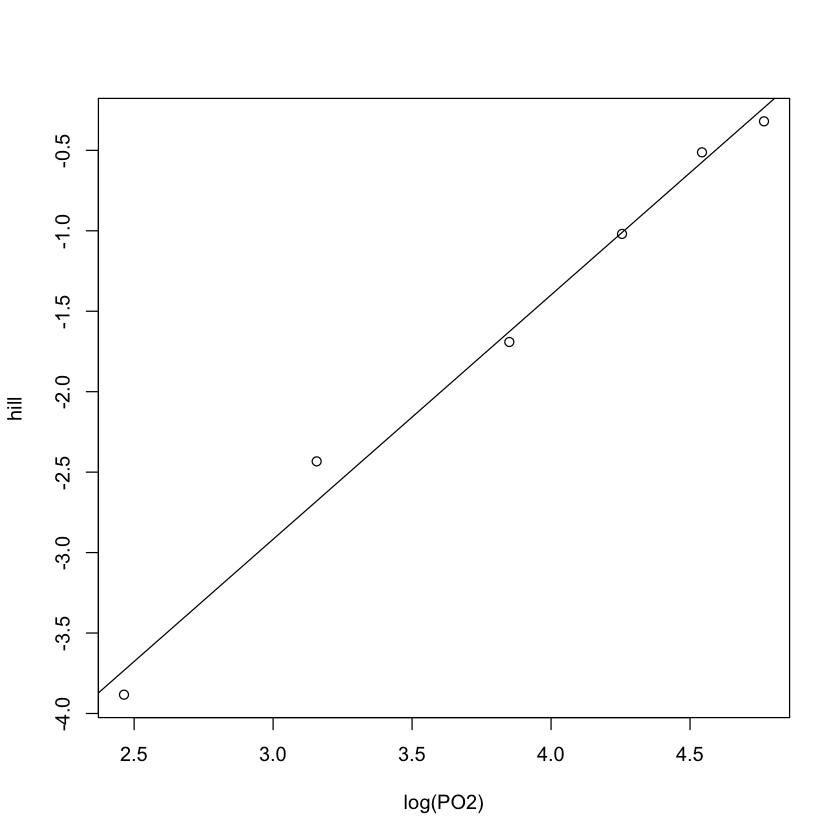

In [11]:
summary(lm(hill~log(PO2), data=hem_68[hem_68$PO2 != 0,]))
plot(hill~log(PO2), data=hem_68[hem_68$PO2 != 0,])
abline(a = -7.47379, b = 1.51877)

In [63]:
anc = aov(hill ~ log(PO2)*pH, data=a[a$PO2 != 0,])
summary(anc)

            Df Sum Sq Mean Sq F value   Pr(>F)    
log(PO2)     1 25.653  25.653 134.458 1.03e-06 ***
pH           1  5.768   5.768  30.231 0.000381 ***
log(PO2):pH  1  0.110   0.110   0.575 0.467652    
Residuals    9  1.717   0.191                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [12]:
# This one is terrible
summary(lm(hill~log(PO2), data=hem_78))
plot(hill~log(PO2), data=hem_78)
abline(a = -21.704, b = 6.674)

ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): NA/NaN/Inf in 'x'


3. Create a magnitude of Bohr Shift graph.


Call:
lm(formula = log(p50) ~ pH)

Residuals:
ALL 2 residuals are 0: no residual degrees of freedom!

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  4.24090         NA      NA       NA
pH          -0.01723         NA      NA       NA

Residual standard error: NaN on 0 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:    NaN 
F-statistic:   NaN on 1 and 0 DF,  p-value: NA


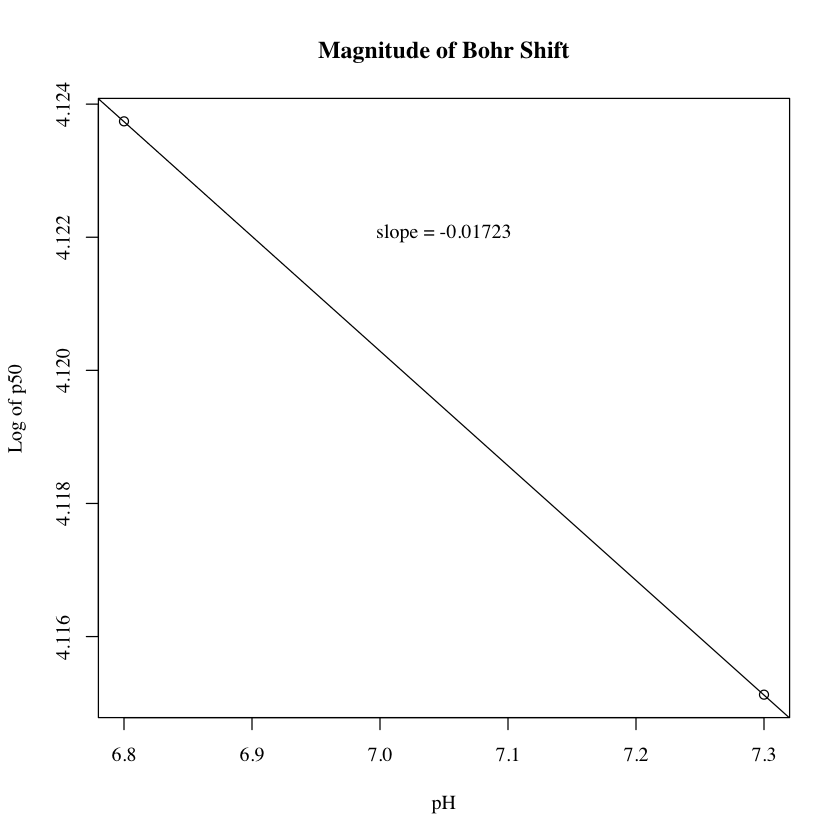

In [137]:
p50 = c(61.79, 61.26)
pH = c(6.8, 7.3)
summary(lm(log(p50)~pH))
#png(filename="MagnitudeBohrShift.png")
par(family = 'serif')
plot(log(p50)~pH, main="Magnitude of Bohr Shift",
    ylab="Log of p50")
abline(a = 4.2409, b=-0.01723)
mtext("slope = -0.01723", 3, line = -6, col = "black")
#dev.off()